In [1]:
# Modules that we need.
import numpy as np
import math
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
# Print the tableau matrix.
def pretty_print_tableau(tableau):
    rows = []
    for row in tableau:
        formatted_row = ["{:>6}".format(str(element)) for element in row]
        rows.append("[ " + " ".join(formatted_row) + "]")
    print("\n".join(rows))

In [3]:
# Pivot operations.
# (Minipivot operation is performed only on the row0).
def pivot(tableau, n, m, t, h, minipivot=False):
    save = tableau[t, h]
    for j in range(n + 1):
        tableau[t, j] = tableau[t, j] / save
    for i in range(m + 1):
        if i != t and tableau[i, h] != 0:
            save = tableau[i, h]
            for j in range(n + 1):
                tableau[i, j] = tableau[i, j] - save * tableau[t, j]
        if minipivot:
            break

In [4]:
# Dual Simplex algorithm.
def dual_simplex(tableau, n, m, beta, x_opt=None, verbose=False):
    unbounded = False
    optimal = False

    itr = 0 # Num of iteration.

    while not optimal and not unbounded:
        if verbose:
            print(f"Current tableau - Itr: {itr}")
            pretty_print_tableau(tableau)

        candidates = [] # Save all the basic variables < 0.
        # Optimality check.
        optimal = True
        for i in range(1, m + 1):
            if tableau[i, 0] < 0:
                optimal = False
                candidates.append(i)

        if not optimal:
            # Choose the var that leaves that basis, according to Bland's rule
            candidates = np.array(candidates)
            t = candidates[0]
            for c in candidates[1:]:
                if beta[c-1] < beta[t]:
                    t = c
                    
            if verbose:
                print(f"x[{beta[t-1]}] leaves the basis.")

            # Unbounded check.
            unbounded = True
            for j in range(1, n + 1):
                if tableau[t, j] < 0:
                    unbounded = False
                    break
            if not unbounded:
                cj_over_aj = np.zeros(n) # Stores the candidates values.
                for j in range(1, n + 1):
                    if tableau[t, j] < 0:
                        cj_over_aj[j-1] = tableau[0, j] / abs(tableau[t, j])
                    else:
                        cj_over_aj[j-1] = float('inf') # Otherwise i can't use 
                                                       # the index returned 
                                                       # by argmin in the tableau.
                                                       # (Sort of placeholder)
                
                # Choose the columns that enters the basis according to Bland's rule.
                h = np.argmin(cj_over_aj)
                h += 1 # Need this to access the corresponding cols in the tableau.

                if verbose:
                    print("Current pivot element =", tableau[t, h])

                pivot(tableau, n, m, t, h) # Update the tableau.

                if verbose:
                    print(f"x[{h}] enters the basis.")
                    print()
                beta[t-1] = h # Update the basis.
                itr += 1

    # Print the optimal solution, if necessary.
    if optimal:
        if verbose:
            print("Optimal solution:")
            print(f"x_B = {[f"x[{i}]" for i in beta]} = {[str(tableau[i, 0]) for i in range(1, m + 1)]}.")
        # Save optimal solution, if necessary.
        if x_opt is not None:
            for i, v in enumerate([tableau[i, 0] for i in range(1, m + 1)]):
                x_opt[i] = v
        minus_bar_c0 = -1 * tableau[0, 0]
        if verbose:
            print(f"Optimal value: {minus_bar_c0}")
        return minus_bar_c0

    print("The problem is unbounded.")
    return float('-inf')

In [5]:
# Simplex Method. This implementation uses the Bland's rule.
def simplex(tableau, n, m, beta, x_opt=None, verbose=False):
    unbounded = False
    optimal = False

    itr = 0 # Num of iteration.

    while not optimal and not unbounded:
        # Save the current vertex, if necessary.
        #if vertices is not None:
        #    vertex = [[beta[i-1], tableau[i, 0].tolist()] for i in range(1, m + 1)]
        #    #vertex = [tableau[i, 0].tolist() for i in range(1, m + 1)]
        #    print("vertex =", vertex)
        #    vertices.append(vertex)

        if verbose:
            print(f"Current tableau - Itr: {itr}")
            pretty_print_tableau(tableau)
        # Optimality test.
        h = -1 # Index of the column that enters the basis.
        optimal = True
        for j in range(1, n + 1):
            if tableau[0, j] < 0:
                optimal = False
                h = j # Choose the var that eneters the basis (Bland's rule).
                if verbose:
                    print(f"x[{h}] enters the basis.")
                break
        if not optimal:
            # Unbounded check.
            unbounded = True
            for i in range(1, m + 1):
                if tableau[i, h] >= 0:
                    unbounded = False
                    break
            if not unbounded:
                bi_over_ai = np.zeros(m) # Stores the theta candidates.
                for i in range(1, m + 1):
                    if tableau[i, h] > 0:
                        bi_over_ai[i-1] = tableau[i, 0] / tableau[i, h]
                    else:
                        bi_over_ai[i-1] = float('inf') # Otherwise i can't use 
                                                       # the index returned 
                                                       # by argmin in the tableau.
                                                       # (Sort of placeholder)
                
                # Choose the columns that leaves the basis according to Bland's rule.
                candidates, = np.nonzero(bi_over_ai == bi_over_ai.min())
                t = candidates[0]
                for c in candidates[1:]:
                    if beta[c] < beta[t]:
                        t = c
                t += 1 # Need this to access the corresponding row in the tableau.

                if verbose:
                    print("Current pivot element =", tableau[t, h])

                pivot(tableau, n, m, t, h) # Update the tableau.

                if verbose:
                    print(f"x[{beta[t-1]}] leaves the basis.")
                beta[t-1] = h # Update the basis.
                itr += 1
                print()

    # Print the optimal solution, if necessary.
    if optimal:
        if verbose:
            print("Optimal solution:")
            print(f"x_B = {[f"x[{i}]" for i in beta]} = {[str(tableau[i, 0]) for i in range(1, m + 1)]}.")
        minus_bar_c0 = -1 * tableau[0, 0]
        # Save solution, if necessary.
        if x_opt is not None:
            for i, v in enumerate([tableau[i, 0] for i in range(1, m + 1)]):
                x_opt[i] = v
        if verbose:
            print(f"Optimal value: {minus_bar_c0}")
        return minus_bar_c0

    print("The problem is unbounded.")
    return float('-inf')

In [6]:
# Phase 1 of the simplex method: find a feasible basis.
def phase1(tableau, n, m, beta, verbose=False):
    original_row0 = tableau[0, :] # Save the original row0.

    # Add to the tableau the identity matrix (y_i variables) and the row0.
    id = np.identity(m, dtype=object)
    for i in range(m):
        for j in range(m):
            id[i, j] = Fraction(id[i, j])
    id = np.vstack(([Fraction(1) for _ in range(m)], id))
    tableau = np.concatenate((tableau, id), axis=1)
    for j in range(n + 1):
        tableau[0, j] = Fraction(0)


    # Update the tableau to transform it in his canonical form.
    for i in range(1, m + 1):
        pivot(tableau, n + m, m, i, n + i, minipivot=True)

    # Solve the artificial problem.
    for i in range(m):
        beta.append(n + i + 1)
    cost = simplex(tableau, n + m, m, beta, verbose=verbose)

    # Check cost value.
    if cost != 0:
        print("The original problem is infeasible")
        return None

    # Check degeneracy cases.
    for i, var in enumerate(beta):
        if var > n:
            print(f"Degeneracy found: variable x[{var}].")
            remove_line = True
            # Find the value of the first bar_aij != 0
            for j in range(1, n + 1):
                if tableau[i+1, j] != 0:
                    pivot(tableau, n + m, m, i+1, j)
                    beta[i] = j
                    print(f"x[{j}] enters and x[{var}] leaves the basis.")
                    remove_line = False # No need to remove the line (A is full rank)
                    break
            if remove_line: # A is not full rank.
                tableau = np.delete(tableau, i+1)


    # Remove the y_i cols and restore the original row0.
    tableau = np.delete(tableau, [n + i + 1 for i in range(m)], axis=1)
    tableau[0, :] = original_row0

    # Update the tableau to transform it in his canonical form.
    for i in range(1, m + 1):
        #print(i, beta[i-1]) # TODO: ERROR: the beta vector must be updated.
        pivot(tableau, n, m, i, beta[i - 1], minipivot=True)

    # Proceed with PHASE 2.
    return tableau

In [7]:
# Check if solution x is integer feasible.
def check_integrality(x, fracidx=None):
    f = True
    for i, v in enumerate(x):
        if not v.is_integer():
            f = False
            if fracidx is not None:
                fracidx.append(i)
    return f

In [13]:
def cutting_plane(A, b, c, maxitr=float("inf"), verbose=False):
    m, n = A.shape # Number of rows and columns

    # Init the tableau in his original form.
    # Add row0.
    tableau = np.array(np.insert(c, 0, Fraction(0)))
    # Add b and A.
    tableau = np.vstack((tableau, np.column_stack((b, A))))

    # Solve the linear relaxation with the simplex.
    if verbose:
        print("\n### Solve the linear relaxation - PHASE 1 ###")
    beta = [] # For the basic variable.
    tableau = phase1(tableau, n, m, beta, verbose=verbose)
    if tableau is None:
        return

    if verbose:
        print("\n### Solve the linear relaxation - PHASE 2 ###")
    x_opt = [0] * m # Optimal solution.
    z_opt = [] # Optimal value.
    z_opt.append(simplex(tableau, n, m, beta, x_opt, verbose=verbose))
    if float("-inf") == z_opt[-1]:
        return


    # Cutting plane algorithm.
    itr = 0
    fracidx = [] # Store index of fractional variables.
    while not check_integrality(x_opt, fracidx) and itr < maxitr: 
        if verbose:
            print(f"\n### CUTTING PLANE ITR {itr} ###")
        # Compute the Gomery's cut, choose the first non integer variable.
        # First compute the values on the new row.
        new_row = np.zeros(tableau.shape[1] + 1, dtype=object)
        new_row[-1] = 1 # Last element is always a one.

        # Select the first fractional variable.
        for i, v in enumerate(tableau[fracidx[0] + 1, :]):
            new_row[i] = Fraction(- (v - math.floor(v))) # The fractional 
                                                         # part of x 
                                                         # (i.e. phi(x))

        if verbose:
            print("\nComputing the AUGMENTED TABLEAU...")
        # Add a new column to the tableau.
        tableau = np.column_stack((tableau, [0] * tableau.shape[0]))
        # Add the new row to the tableau.
        tableau = np.vstack((tableau, new_row))
        #pretty_print_tableau(tableau)

        # Add new element to the basis and to the optimal solution list.
        beta.append(tableau.shape[1] - 1)
        x_opt.append(0)

        # Update number of rows and columns.
        n += 1
        m += 1

        # Solve the linear relaxation (dual simplex).
        if verbose:
            print("\n### Dual simplex ###")
        z_opt.append(dual_simplex(tableau, n, m, beta, x_opt, verbose=verbose))
        if float("-inf") == z_opt[-1]:
           break 
        
        # Clear the fractinal index list.
        fracidx = []

        itr += 1

    # Plot the results.
    plot_zopt(z_opt)

In [14]:
def plot_zopt(z_opt):
    plt.plot(range(len(z_opt)), z_opt)
    plt.axhline(z_opt[-1], color="green", linestyle="--")
    plt.show

In [15]:
# Define the problem (Simple problem from the book).
A = np.array(
    [[Fraction(2), Fraction(2), Fraction(1), Fraction(0), Fraction(0)],
    [Fraction(1), Fraction(3), Fraction(0), Fraction(1), Fraction(0)],
    [Fraction(2), Fraction(1), Fraction(0), Fraction(0), Fraction(1)]]
)
b = np.array([Fraction(8), Fraction(7), Fraction(5)])
c = np.array([Fraction(-4), Fraction(-5), Fraction(0), Fraction(0), Fraction(0)])

In [16]:
# Define the probelm (more interesting problem from MIPLIB2022 - ej).
A = np.array([[31013, -41014, -51015]]) * -1

b = np.array([31013])
c = np.array([1, 0, 0])

to_fraction = lambda x: Fraction(x)
vfun = np.vectorize(to_fraction)
A = vfun(A)
b = vfun(b)
c = vfun(c)

The model:
```
Minimize
 obj: x0
Subject To
 c1: 31013 x0 - 41014 x1 - 51015 x2  = 0
Bounds
      x0 >= 1
      x1 >= 0
      x2 >= 0
Generals
 x0  x1  x2
```
We need to define a new variable $x_0^\prime = x_0 - 1$.
So the constraint now is $31013 x_0^\prime - 41014 x_1 - 51015 x_2  = -31013$, by multiplying it by -1 we get
$-31013 x_0^\prime + 41014 x_1 + 51015 x_2  = 31013$.

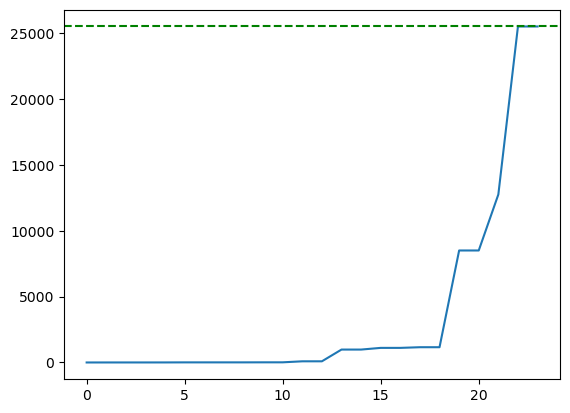

In [17]:
# Call the Cutting Plane algorithm.
cutting_plane(A, b, c, maxitr= 60, verbose=False)